# Compute scattering coefficients

Edited by Louise, 28-02-2023

We show how to compute scattering coefficients. Starting with axisymmetric wavelets.


In [109]:
from jax import jit, config
config.update("jax_enable_x64", True)

import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
from importlib import reload

from PIL import Image
from matplotlib.image import pil_to_array

import scatcovjax.Sphere_lib as sphlib
import scatcovjax.Scattering_lib as scatlib
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft

# Parameters

In [181]:
sampling = "mw"
nside = 32
multiresolution = True
reality = True
L = 3 * nside
N = 1
J_min = 0

# Make a data map

(96, 191)


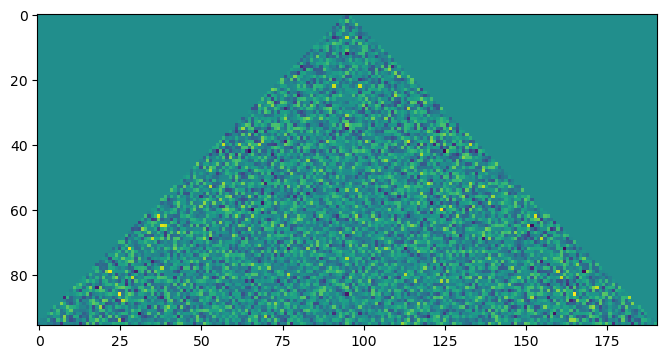

In [182]:
reload(sphlib)
# Random noise
np.random.seed(0)
I = np.random.randn(L, 2 * L - 1).astype(np.float64)

# Planet image
# I = sphlib.make_hpx_planet(nside=nside, planet='venus', interp=True, normalize=False)
# grayscale_pil_image = Image.open('../texture_maps/venus.jpg').convert("L")
# I = pil_to_array(grayscale_pil_image)

# SHT forward transform
Ilm = s2fft.forward_jax(I, L, sampling=sampling, nside=nside)
print(Ilm.shape)

# Plot the map
# plt.figure(figsize=(8, 6))
# plt.imshow(I)
# hp.mollview(I)

plt.figure(figsize=(8, 6))
plt.imshow(np.real(Ilm))

# Build the wavelets

(8, 96, 191)


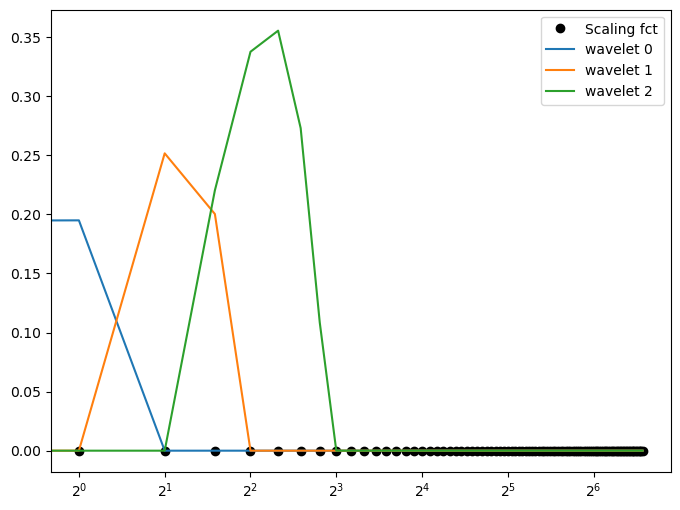

In [183]:
filters = filters_directional_vectorised(L, N, J_min)
print(filters[0].shape)

plt.figure(figsize=(8, 6))
plt.plot(filters[1], 'ko', label='Scaling fct')
for j in range(3):
    plt.plot(np.real(filters[0])[j, :, L-1], label=f'wavelet {j}')
plt.xscale('log', base=2)
plt.legend()

# Compute the scattering coefficients

In [123]:
reload(scatlib)
# Compute the coeff
mean, var, S1, P00, C01, C11 = scatlib.scat_cov_axi(
    Ilm, L, N, J_min, sampling, nside, reality, multiresolution, filters)

S1 = np.array(S1)
P00 = np.array(P00)

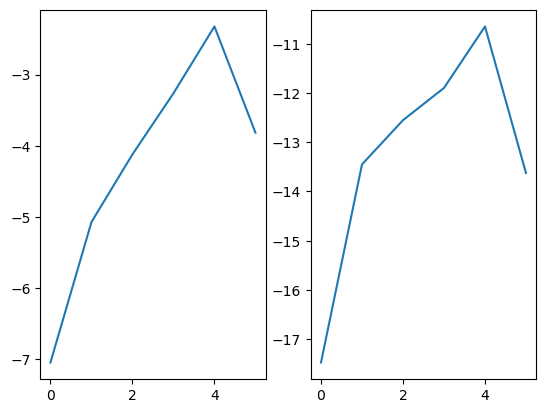

In [124]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.log2(S1)[:])
ax2.plot(np.log2(P00)[:])
plt.show()

# Check on white noise

In [189]:
# Check that C01 is compatible with 0 for white noise
nreals = 100
S1_all, P00_all, C01_all, C11_all = [], [], [], []
for i in range(nreals):
    print('real:', i)
    I = np.random.randn(L, 2 * L - 1).astype(np.float64)
    Ilm = s2fft.forward_jax(I, L, sampling=sampling, nside=nside)

    mean, var, S1, P00, C01, C11 = scatlib.scat_cov_axi(
        Ilm, L, N, J_min, sampling, nside, reality, multiresolution, filters)

    S1_all.append(np.array(S1))
    P00_all.append(np.array(P00))
    C01_all.append(np.hstack(C01))
    newC11 = []  # Just a trick to get C11 in a 1D array
    for c in C11:
        newC11.append(np.hstack(c))
    C11_all.append(np.hstack(np.hstack(newC11)))

S1_all = np.array(S1_all)
P00_all = np.array(P00_all)
C01_all = np.array(C01_all)
C11_all = np.array(C11_all)

real: 0
real: 1
real: 2
real: 3
real: 4
real: 5
real: 6
real: 7
real: 8
real: 9
real: 10
real: 11
real: 12
real: 13
real: 14
real: 15
real: 16
real: 17
real: 18
real: 19
real: 20
real: 21
real: 22
real: 23
real: 24
real: 25
real: 26
real: 27
real: 28
real: 29
real: 30
real: 31
real: 32
real: 33
real: 34
real: 35
real: 36
real: 37
real: 38
real: 39
real: 40
real: 41
real: 42
real: 43
real: 44
real: 45
real: 46
real: 47
real: 48
real: 49
real: 50
real: 51
real: 52
real: 53
real: 54
real: 55
real: 56
real: 57
real: 58
real: 59
real: 60
real: 61
real: 62
real: 63
real: 64
real: 65
real: 66
real: 67
real: 68
real: 69
real: 70
real: 71
real: 72
real: 73
real: 74
real: 75
real: 76
real: 77
real: 78
real: 79
real: 80
real: 81
real: 82
real: 83
real: 84
real: 85
real: 86
real: 87
real: 88
real: 89
real: 90
real: 91
real: 92
real: 93
real: 94
real: 95
real: 96
real: 97
real: 98
real: 99


In [190]:
# Normalize by the STD over realisations
stdS1 = np.std(S1_all, axis=0)
stdP00 = np.std(P00_all, axis=0)
stdC01 = np.std(C01_all, axis=0)
stdC11 = np.std(C11_all, axis=0)

avgS1 = np.mean(S1_all, axis=0)
avgP00 = np.mean(P00_all, axis=0)
avgC01 = np.mean(C01_all, axis=0)
avgC11 = np.mean(C11_all, axis=0)

In [191]:
stdC11.shape

(56,)

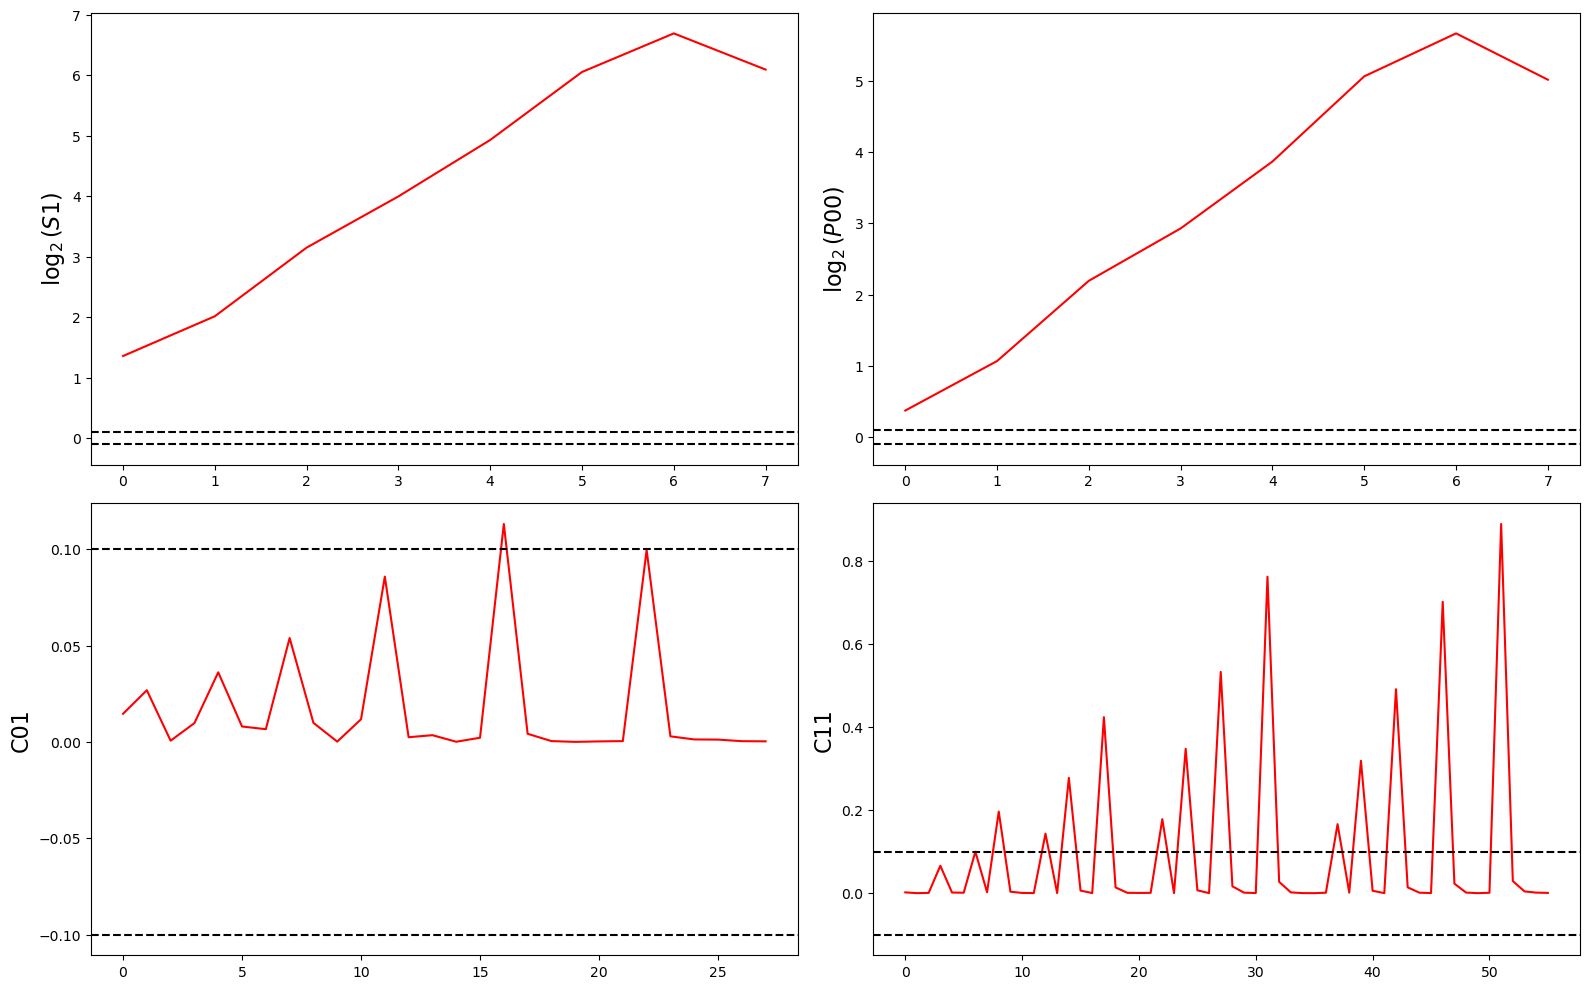

In [197]:
def forplot(ax):
    # ax.legend(fontsize=16)
    ax.axhline(-1/np.sqrt(nreals), color='k', ls='--')
    ax.axhline(1/np.sqrt(nreals), color='k', ls='--')
    return

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.ravel()

axs[0].plot(np.log2(avgS1 / stdS1), 'r')
axs[0].set_ylabel(r'$\log_2(S1)$', fontsize=16)
forplot(axs[0])

axs[1].plot(np.log2(avgP00 / stdP00), 'r')
axs[1].set_ylabel(r'$\log_2(P00)$', fontsize=16)
forplot(axs[1])

axs[2].plot(np.abs(avgC01), 'r')
axs[2].set_ylabel('C01', fontsize=16)
forplot(axs[2])
# axs[2].set_yscale('log')

axs[3].plot(np.abs(avgC11), 'r')
axs[3].set_ylabel('C11', fontsize=16)
forplot(axs[3])
# axs[3].set_yscale('log')

fig.tight_layout()